In [232]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from torchsummary import summary

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


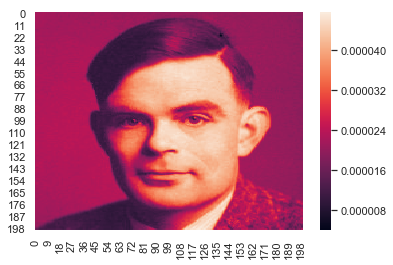

In [233]:
p_x = np.load('distribution.npy')
sns.heatmap(p_x)

In [240]:
def loss_NLL(x, x_hat):
    loss = 0
    batch_size = x.size(0)
    ind = np.arange(400)
    ind_even = np.where(ind % 2 == 0)[0]
    ind_odd = np.where(ind % 2 == 1)[0]
    
    # 
    # 1) - get all the softmax out pt for x1 and x2
    # 2) - get the softmax output for the correct class for x1 and x2 (x_1_prob_correct_class , x_2_prob_correct_class)
    #    - x[:,0] is used to get the correct class and long() is necessary for slicing 
    # 3) - get the mean of log(prob_correct_classes) for the batch
    
    x_1_probs_all = x_hat[:, ind_even]
    x_1_prob_correct_class = x_1_probs_all[np.arange(batch_size), x[:, 0].long()]
    loss += - (x_1_prob_correct_class.log2()).mean(dim=-1)
    
    x_2_probs_all = x_hat[:, ind_odd]
    x_2_prob_correct_class = x_2_probs_all[np.arange(batch_size), x[:, 1].long()]
    loss += - (x_2_prob_correct_class.log2()).mean(dim=-1)
    
    return loss


def train_validate(model, data, optim, loss_fn, train):
    
    model.train() if train else model.eval()
    
    batch_size = 128
    num_iter = data.size(0) // batch_size
    loss_epoch = 0
        
    for i in range(num_iter):
        if train:
            perm = torch.randperm(data.size(0))
            idx = perm[:batch_size]
            x = data[idx]
        else:
            x  = data[i * batch_size: (i + 1) * batch_size]
            
        x_hat = model(x)
    
        loss = loss_fn(x, x_hat)
        loss_epoch += loss.item()
        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()

    return loss_epoch / num_iter / 2


def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)

In [241]:
class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones([out_features, in_features]))
        self.reset_parameters()

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    def set_mask(self, mask):
        mask = torch.from_numpy(mask.astype(np.uint8).T).type(torch.FloatTensor)
        if not (self.mask.data.size() == mask.size()):
            raise Exception('size mask mismatch')
        self.mask.data.copy_(mask)
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)
     
    
class MADE1(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, shuffle_input=False):
        super(MADE1, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.shuffle_input = shuffle_input
        self.hs = [self.input_size] + self.hidden_sizes + [self.output_size]
        
        self.network = []
        for in_feat, out_feat in zip(self.hs, self.hs[1:]):
            self.network.extend([
                            nn.BatchNorm1d(in_feat),
                            MaskedLinear(in_feat, out_feat),
                            nn.ReLU(),
                            ])
        self.network.pop()
        self.network = nn.Sequential(*self.network)
        # set all masks
        self.init_masks()
        
    def init_masks(self):
        # Build the masks
        L = len(self.hidden_sizes)
        m = {}
        m[-1] = rng.permutation(self.input_size) if self.shuffle_input else np.arange(self.input_size)
        
        rng = np.random.RandomState(0)
        for l in range(L):
            m[l] = rng.randint(min(m[l - 1]), self.input_size - 1, size=self.hidden_sizes[l])

        # Build W Masks
        masks = []
        for l in range(L):
            W = m[l-1][:, None] <= m[l][None, :]
            masks.append(W)
        # V mask
        V = m[L-1][:, None] < m[-1][None, :]
        masks.append(V)
        
        # copied from karpathy
        if self.output_size > self.input_size:
            k = self.output_size // self.input_size
            # replicate the last mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)

        # Set masks in network
        mask_layers = [l for l in self.network.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(mask_layers, masks):
            layer.set_mask(mask)
        
    def forward(self, x):
        x = self.network(x)
        x = F.softmax(x, dim=-1)
        return x    

In [242]:
# Sample 100.000 points from this distribution, split 80/20 test train
samples = np.random.choice(np.prod(p_x.shape), p=p_x.ravel(), size=100000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train_data, valid_data = train_test_split(samples, test_size=0.2)

train_data = torch.from_numpy(train_data).type(torch.FloatTensor)
valid_data = torch.from_numpy(valid_data).type(torch.FloatTensor)

d = 2
n_classes = 200
input_size = 2
output_size = input_size * n_classes
hidden_sizes = [20, 20]

model = MADE1(input_size, hidden_sizes, output_size, False)

optim = Adam(model.parameters(), lr=0.001)
loss_fn = loss_NLL
n_epochs = 20

train_loss = []
val_loss = []
for epoch in range(0, n_epochs):   
    t_loss = train_validate(model, train_data, optim, loss_fn, train=True)
    train_loss.append(t_loss)
    
    if epoch % 100 == 0:
        model.init_masks()
        v_loss = train_validate(model, valid_data, optim, loss_fn, train=False)
        val_loss.append(v_loss)

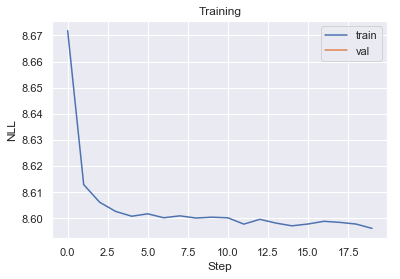

In [243]:
# sns.set()
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 100, 100), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)

In [248]:
def gen_output(model,nsamples=100000):
        model.eval()
        x = torch.zeros([nsamples, 2]) 
        # steps:       
        # P(x1,x2) = P(x1)*P(x2|x1)
        # to generate samples we have to get the P(x1) and P(x2|x1)
        # and sample from them
        
        # P(x1) 
        # - P(x1) is parametrized by 200 even indices in the output
        # - because it does not depend on any input we initialize the input to the model to zeros
        # - get the softmax outputs for P(x1) and assign a torch.Categorical distribution to them 
        # - sample from the distribution
        
        # P(x2|x1) 
        # - P(x2|x1) is parametrized by 200 even indices in the output
        # - because it does depend on x1 we change the x1 to the output samples we got previously 
        # - get the softmax outputs for P(x2|x1) and assign a torch.Categorical distribution to them 
        # - sample from the distribution
        
        x_hat = model(x)
        
        ind = np.arange(400)
        ind_even = np.where(ind % 2 == 0)[0]
        ind_odd = np.where(ind % 2 == 1)[0]
        
        output_prob_x1 = x_hat[:, ind_even]
        output_prob_x1 = torch.log(output_prob_x1)
        dist_x1 = torch.distributions.Categorical(logits=output_prob_x1)
        x1_samples = dist_x1.sample()
        x[:, 0] = x1_samples[:]
        
        x_hat = model(x)
        output_prob_x2 = x_hat[:, ind_odd]
        output_prob_x2 = torch.log(output_prob_x2)
        dist_x2 = torch.distributions.Categorical(logits=output_prob_x2)
        x2_samples = dist_x2.sample()
        x[:, 1] = x2_samples[:]

        output = x.numpy()
        return output


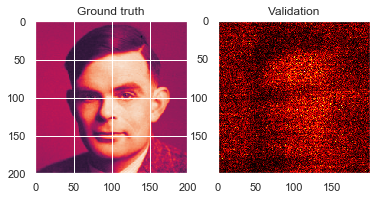

In [249]:
output = gen_output(model,nsamples=100000)

fig, axis = plt.subplots(nrows=1, ncols=2)

axis[0].imshow(p_x)
axis[0].set_title('Ground truth')

axis[1].hist2d(output[:, 0], output[:, 1], bins=200, range=[[0,199], [0, 199]], cmap=plt.get_cmap('hot'))
axis[1].set_title('Validation')
axis[1].set_aspect('equal', 'box')
axis[1].invert_yaxis()


200